In [3]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [26]:
import tensorflow as tf
from DifferentiableHOS.statistics import find_peaks2d_tf, peaks_histogram_tf, non_diffable_peaks_histogram_tf
from DifferentiableHOS.transforms import starlet2d

In [6]:
# Load test convergence map
kTNG = np.load('kappa_tng.npy').reshape([1024, 1024]).astype('float32')
skTNG = starlet2d(kTNG.reshape([1,1024,1024]))[1][0,:,:,0]

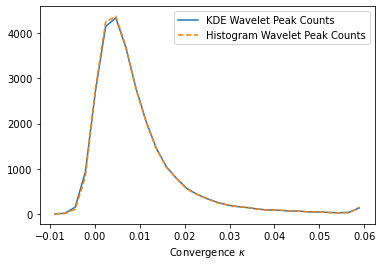

In [82]:
# First, let's compare histograms
bins = tf.linspace(-0.01, 0.06, 32)
ref_counts, ref_bins = non_diffable_peaks_histogram_tf(skTNG, bins=bins)

bins = 0.5*(bins[0:-1] + bins[1:])
counts, bins = peaks_histogram_tf(skTNG, bins=bins)


plot(bins, counts, label='KDE Wavelet Peak Counts')
plot(bins, ref_counts, '--', label='Histogram Wavelet Peak Counts')
xlabel(r'Convergence $\kappa$')
legend()
savefig('peakcounts.png', transparent=True, bbox_inches='tight')

In [ ]:
# Ok, great, now the question is whether this gives us nice gradients

In [71]:
@tf.function
def func(kmap):
    kmap=tf.cast(kmap,dtype=tf.float32)
    r = starlet2d(tf.reshape(kmap, [1,64,64]))[1][0,:,:,0]
    bins = tf.linspace(-0.01, 0.06, 16)
    bins = 0.5*(bins[0:-1] + bins[1:])
    counts, _ = peaks_histogram_tf(r,bins=bins)
    counts=tf.reduce_sum(counts**2)
    return counts

@tf.function
def compute_gradient_diff(kmap):
  """ Function that actually computes the Jacobian of a given statistics
  """
  kmap = tf.convert_to_tensor(kmap, dtype=tf.float32)
  with tf.GradientTape() as tape:
    tape.watch(kmap)
    counts = func(kmap)
  jac = tape.gradient(counts, kmap)
  return jac

In [72]:
import numdifftools as nd
dl1=nd.Gradient(func)
dl1_np=dl1(kTNG[:64,:64])

In [73]:
dl2_tf = compute_gradient_diff(kTNG[:64,:64])

Text(0.5, 1.0, 'autodiff')

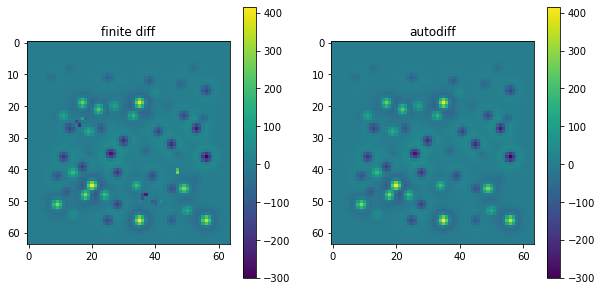

In [75]:
figure(figsize=[10,5])
subplot(121)

imshow(dl1_np.reshape([64,64]));colorbar()
title('finite diff')
subplot(122)

imshow((dl2_tf.numpy())); colorbar()
title('autodiff')

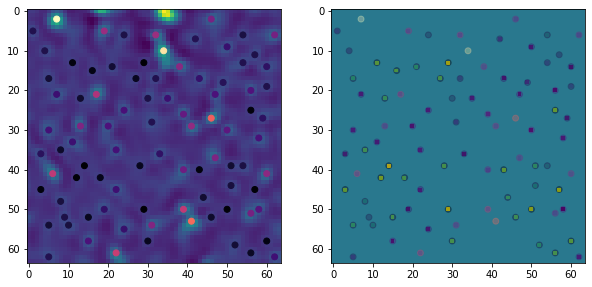

In [70]:
figure(figsize=[10,5])
subplot(121)
x, y, heights = find_peaks2d_tf(skTNG[:64,:64])
imshow(skTNG[:64,:64])
scatter(y,x, c=heights, cmap='magma')

subplot(122)
imshow(dl2_tf.numpy())
scatter(y,x, c=heights, cmap='magma',alpha=0.3)
